## Let's try RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

random.seed(0)


In [2]:
DATA_DIR = "./generated_data"
CSV_NAME = "generated_data_1.csv"

## Merge CSVs

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, CSV_NAME))

# for csv_name in os.listdir(DATA_DIR):
#     if csv_name == CSV_NAME:
#         continue
#     df = pd.concat([df, pd.read_csv(os.path.join(DATA_DIR, csv_name))])

# df = df.interpolate() # to prevent nan in model output
# df.head()


# df = pd.read_csv(os.path.join(DATA_DIR, CSV_NAME))
# df = pd.DataFrame()
# for csv_name in os.listdir(DATA_DIR):
#     print(list(df.columns))
#     if csv_name == CSV_NAME:
#         continue
#     df = pd.concat([df, pd.read_csv(os.path.join(DATA_DIR, csv_name))])    

df = df.dropna(axis=1) # to prevent nan in model output
df.head()


,noisy motion,kalman prediction,ground truth,motion noise stdev,laser noise stdev,laser range 1,laser range 2,laser range 3,laser range 4,laser range 5,laser range 6
0,-1.155220,3.551487,3.268738,2,0.01,6.463386,6.457985,6.450579,6.449560,6.465331,6.462147
1,-0.344686,3.759194,3.941828,2,0.01,6.305038,6.282087,6.263595,6.265825,6.249935,6.243805
2,-0.265481,4.417085,4.019310,2,0.01,5.602849,5.594613,5.582178,5.580036,5.585974,5.587743
3,0.465647,4.499272,4.404337,2,0.01,5.538476,5.515565,5.505001,5.503956,5.516458,5.535148
4,0.182628,4.881963,4.111349,2,0.01,5.140490,5.114725,5.125316,5.132672,5.123336,5.125902


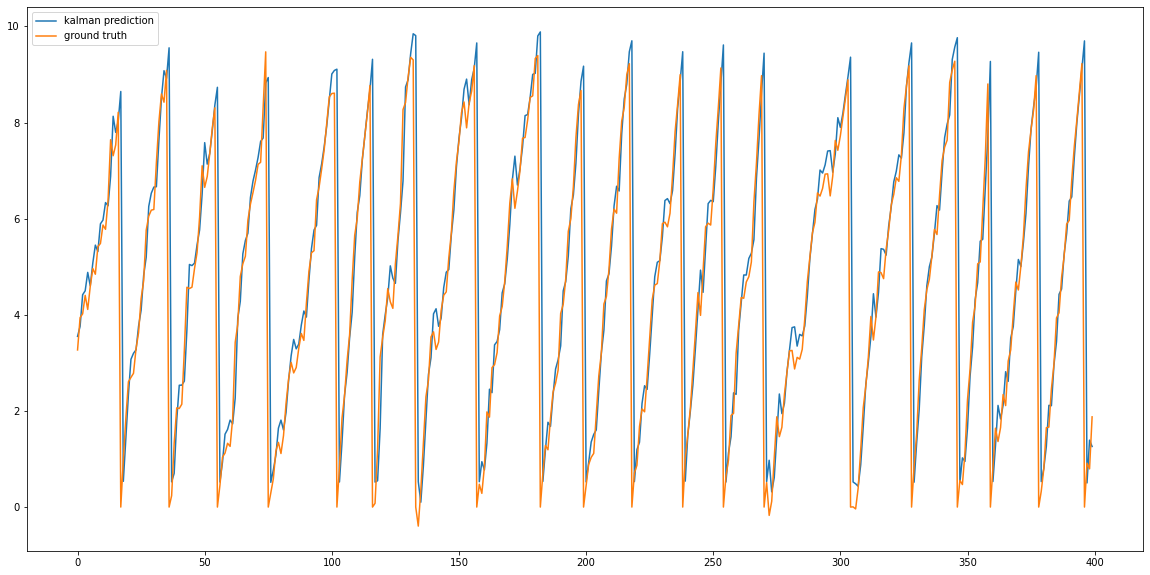

In [4]:
# Split
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)



# sanity checks

# kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

split = 400


plt.figure(figsize=(20, 10))
plt.plot(df['kalman prediction'].to_list()[:split])
plt.plot(df['ground truth'].to_list()[:split])

plt.legend(['kalman prediction', 'ground truth'])




In [5]:
# df[df.isna().values]

## Model

In [6]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    # def forward(self, x, h0):
    def forward(self, x):
        # h0 from the last batch

        # print(x.shape)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # print(h0.shape, torch.zeros(1, x.size(0), self.hidden_size).to(x.device).shape)
        out, _ = self.rnn(x, h0)
        if out.isnan().any():
            print("NAN:", out)
        fc_out = self.fc(out[:, -1, :]) # taking only the last hidden layer output
        # print(fc_out.shape, out.shape)
        if out.isnan().any():
            print("NAN: Second: ", out)
        return fc_out, out

## Reshape csv as per the seq length and batch size

In [7]:
def get_input_data(train_df, seq_len, batch_size, num_batches):

       labels = np.array(train_df["ground truth"].to_list())
       input_data_df = train_df[['noisy motion', 'motion noise stdev', 'laser noise stdev', 'laser range 1',
              'laser range 2', 'laser range 3', 'laser range 4', 'laser range 5',
              'laser range 6']].to_numpy()

       # input_data = input_data_df[:num_batches * batch_size]
       input_data = input_data_df.copy()

       # output_data = labels[:num_batches * batch_size]
       output_data = labels.copy()



       new_input_data = []
       new_output_data = []

       for i in range(len(input_data) - seq_len):
              new_input_data.append(input_data[i:i+seq_len])
              new_output_data.append(output_data[i + seq_len -1])

       new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
       new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch
       
       return new_input_data, new_output_data


In [8]:
# new_input_data = []
# new_output_data = []

# for i in range(len(input_data) - seq_len):
#     new_input_data.append(input_data[i:i+seq_len])
#     new_output_data.append(output_data[i + seq_len -1])

# new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
# new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch



In [9]:
# new_input_data.shape

In [10]:
# # sanity check
# print(new_input_data[0][-1], new_output_data[0].round(6))
# train_df.iloc[seq_len - 1]["ground truth"].round(6) == new_output_data[0].round(6)

# train_df.iloc[seq_len - 1]

In [11]:
seq_len = 50
batch_size = 10
num_batches = (len(train_df) - seq_len) // (batch_size)

new_input_data, new_output_data=  get_input_data(df, seq_len = seq_len, batch_size = batch_size, num_batches = num_batches)


new_input_data.shape == (num_batches* batch_size, seq_len, new_input_data.shape[-1])

True

In [12]:
# split
# train_input_data = new_input_data[:num_batches* batch_size//2]
# train_output_data = new_output_data[:num_batches* batch_size//2]
# new_input_data[:len(new_input_data)*0.8, ].shape

test_idx = random.sample(range(len(new_input_data)), k = int(len(new_input_data)*0.2))
train_idx = [i for i in range(len(new_input_data)) if i not in test_idx]

test_input = new_input_data[test_idx]
test_output = new_output_data[test_idx]

train_input = new_input_data[train_idx]
train_output = new_output_data[train_idx].reshape(-1, 1)


In [13]:
train_output.shape

(632, 1)

In [14]:
# train_input.shape, train_output.shape, test_input.shape, test_output.shape

# train_input.shape, batch_size, (train_input.shape[0]//batch_size)*batch_size
# 

# get pytorch csv dataloader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_input).float(), torch.from_numpy(train_output).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input).float(), torch.from_numpy(test_output).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False , drop_last=True)

## Gear Up | Train | Launch

In [22]:
input_size = 9
output_size = 1
hidden_size = 256
lr = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleRNN(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion_l1 = nn.L1Loss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Train the model
loss_cache = []


num_epochs = 200
for epoch in range(num_epochs):
    # hidden layer of the last batch
    # prev_batch_hidden = torch.zeros((1, batch_size, hidden_size)).to(device)

    # for i in range(len(train_input)):
    for inputs, targets in train_loader:
        # batch_inputs = train_input[i].to(device)
        # batch_outputs = train_target[i].to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # print(batch_inputs.shape, batch_outputs.shape)
        # break

        optimizer.zero_grad()
        # output, hidden_output = model(inputs, prev_batch_hidden)
        output, hidden_output = model(inputs)
        # prev_batch_hidden = prev_batch_hidden
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %10 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/200], Loss: 10.7758
Epoch [11/200], Loss: 5.9121
Epoch [21/200], Loss: 5.8408
Epoch [31/200], Loss: 5.3771
Epoch [41/200], Loss: 6.7592
Epoch [51/200], Loss: 6.5141
Epoch [61/200], Loss: 6.1486
Epoch [71/200], Loss: 6.5018
Epoch [81/200], Loss: 5.1263
Epoch [91/200], Loss: 6.9650
Epoch [101/200], Loss: 2.7290
Epoch [111/200], Loss: 2.8052
Epoch [121/200], Loss: 2.1889
Epoch [131/200], Loss: 5.1544
Epoch [141/200], Loss: 4.0850
Epoch [151/200], Loss: 4.2472
Epoch [161/200], Loss: 3.7139
Epoch [171/200], Loss: 2.2632
Epoch [181/200], Loss: 2.9262
Epoch [191/200], Loss: 1.8644


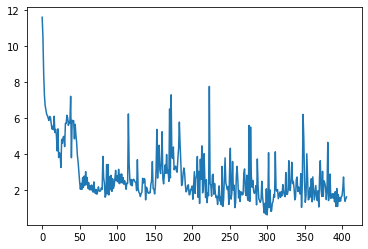

In [17]:
plt.plot(loss_cache)

## Pred

In [18]:
# test_input_df = test_df.drop(columns=["ground truth", "kalman prediction"])
# test_output_df = test_df["ground truth"]
# test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input_df.to_numpy()).type(torch.float32), torch.from_numpy(test_output_df.to_numpy()).type(torch.float32))
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_cache = []
test_pred = []
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device).view(-1, 1)
        # outputs = outputs
        pred, _ = model(inputs)
        test_pred.append(pred)
        loss = criterion(pred, outputs)
        # print(loss.item())
        loss_cache.append(loss.item())

In [19]:
sum(loss_cache)

42.6346340328455

In [20]:
# reshape test_pred to 1d
test_pred = torch.cat(test_pred, dim=0)

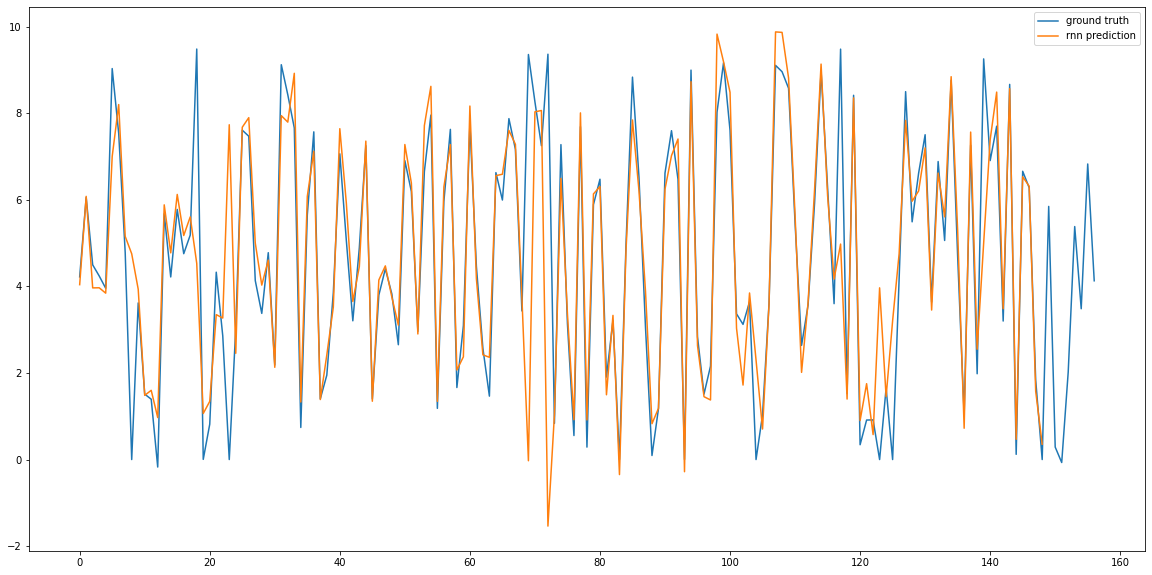

In [21]:
# kf_pred = torch.tensor(test_df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(test_df['ground truth'].to_list()).reshape(-1, 1)

# gt.shape, kf_pred.shape


split = -1


plt.figure(figsize=(20, 10))
# plt.plot(test_df['kalman prediction'].to_list()[:split])
plt.plot(test_output[:split])
plt.plot(test_pred.detach().cpu()[:split])

# plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])
plt.legend(['ground truth', 'rnn prediction'])
# plt.plot(pred.to_list())


